<a href="https://colab.research.google.com/github/pointerness/udacity_capstone/blob/master/Udacity_Capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data upload

In [0]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

## Upload Kaggle Data

In [2]:
from google.colab import  files
files.upload()
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle/

Saving kaggle.json to kaggle (1).json
kaggle.json


In [3]:
!kaggle datasets list

ref                                                    title                                          size  lastUpdated          downloadCount  
-----------------------------------------------------  --------------------------------------------  -----  -------------------  -------------  
vjchoudhary7/customer-segmentation-tutorial-in-python  Mall Customer Segmentation Data                 2KB  2018-08-11 07:23:02          17329  
russellyates88/suicide-rates-overview-1985-to-2016     Suicide Rates Overview 1985 to 2016           396KB  2018-12-01 19:18:25          42025  
iarunava/cell-images-for-detecting-malaria             Malaria Cell Images Dataset                   337MB  2018-12-05 05:40:21           9600  
bigquery/crypto-ethereum-classic                       Ethereum Classic Blockchain                    70GB  2019-03-20 23:21:25              0  
jessicali9530/stanford-dogs-dataset                    Stanford Dogs Dataset                         735MB  2019-02-13 05:45:25   

In [4]:
!kaggle datasets download -d mlg-ulb/creditcardfraud

creditcardfraud.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
!ls
!pwd

 creditcardfraud.zip  'kaggle (1).json'   kaggle.json   sample_data
/content


# Data Exploration

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
data = pd.read_csv('/content/creditcardfraud.zip',compression='zip',header=0,sep=',',quotechar='"')

In [8]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [9]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


### Getting some insight into the data

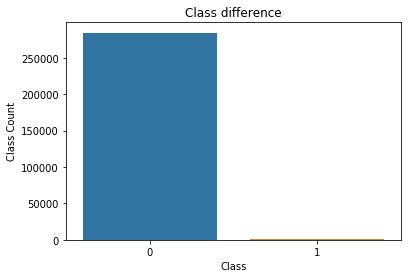

In [10]:
import seaborn as sns
g = sns.countplot(x='Class', data=data)
g.set_ylabel('Class Count')
g.set_title('Class difference')
plt.show()

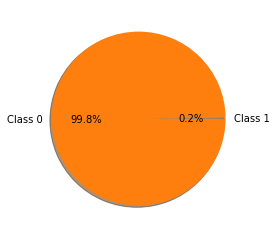

In [11]:
labels = ['Class 1', 'Class 0']
sizes = [data['Class'].value_counts()[1], data['Class'].value_counts()[0]]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True)
plt.show()

Here we can see that the fraud data is really less. Only **0.2%** of the actual data are fraud data. So we will have to be real careful when we are trying the split the data for train-test split.


In [0]:
from sklearn.preprocessing import StandardScaler

In [0]:
data['normAmount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1,1))


In [14]:
data = data.drop(['Time','Amount'],axis=1)
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,normAmount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403


2. Assigning X and Y. No resampling.

In [15]:
X = data.iloc[:, data.columns != 'Class']
y = data.iloc[:, data.columns == 'Class']
display(X.head())
display(y.head())

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,normAmount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403


,Class
0,0
1,0
2,0
3,0
4,0


### Applying SMOTE with Over Sampling

In [0]:
#Apply SMOTE to create synthetic observations from minority class
#Source:https://github.com/scikit-learn-contrib/imbalanced-learn

In [17]:
from imblearn.over_sampling import SMOTE #Over sampling
sm = SMOTE(ratio='auto',kind='regular')
X_over_sampled, y_over_sampled = sm.fit_sample(X,y.values.ravel())
display(X_over_sampled)
display(y_over_sampled)


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


array([[-1.35980713e+00, -7.27811733e-02,  2.53634674e+00, ...,
         1.33558377e-01, -2.10530535e-02,  2.44964263e-01],
       [ 1.19185711e+00,  2.66150712e-01,  1.66480113e-01, ...,
        -8.98309914e-03,  1.47241692e-02, -3.42474541e-01],
       [-1.35835406e+00, -1.34016307e+00,  1.77320934e+00, ...,
        -5.53527940e-02, -5.97518406e-02,  1.16068593e+00],
       ...,
       [-1.42339530e+01,  9.16795587e+00, -1.78918400e+01, ...,
        -2.19623454e+00, -4.51539912e-01, -2.47810750e-01],
       [-5.77343775e+00,  6.86875053e+00, -1.27850449e+01, ...,
        -3.61913647e-04,  4.21912862e-01, -1.95611966e-01],
       [ 1.29590092e+00,  4.17445702e-01,  1.94989492e-01, ...,
         3.28198896e-02,  2.05847905e-02, -3.48509566e-01]])

array([0, 0, 0, ..., 1, 1, 1])

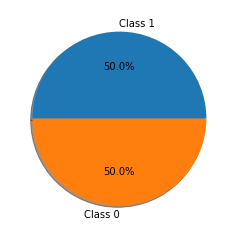

In [52]:
labels = ['Class 1', 'Class 0']
sizes = [len(y_over_sampled[y_over_sampled==1]),len(y_over_sampled[y_over_sampled==0])]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True)
plt.show()

In [18]:
#Percentage of fraudlent records in original data
Source_data_no_fraud_count = len(data[data.Class==0])
Source_data_fraud_count = len(data[data.Class==1])
print('Percentage of fraud counts in original dataset:{}%'.format((Source_data_fraud_count*100)/(Source_data_no_fraud_count+Source_data_fraud_count)))

Percentage of fraud counts in original dataset:0.1727485630620034%


In [19]:
#Percentage of fraudlent records in sampled data
Sampled_data_no_fraud_count = len(y_over_sampled[y_over_sampled==0])
Sampled_data_fraud_count = len(y_over_sampled[y_over_sampled==1])
print('Percentage of fraud counts in the new data:{}%'.format((Sampled_data_fraud_count*100)/(Sampled_data_no_fraud_count+Sampled_data_fraud_count)))

Percentage of fraud counts in the new data:50.0%


#### Splitting data into train and test set. Cross validation will be used when calculating accuracies.

In [0]:
from sklearn.model_selection import train_test_split

##### Splitting whole dataset

In [21]:
# Whole dataset
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25, random_state = 0, shuffle=True)

print("Number transactions train dataset: ", len(X_train))
print("Number transactions test dataset: ", len(X_test))
print("Total number of transactions: ", len(X_train)+len(X_test))

Number transactions train dataset:  213605
Number transactions test dataset:  71202
Total number of transactions:  284807


##### Splitting oversampled dataset

In [22]:
# oversampled dataset
X_train_sampled, X_test_sampled, y_train_sampled, y_test_sampled = train_test_split(X_over_sampled
                                                                                   ,y_over_sampled
                                                                                   ,test_size = 0.25
                                                                                   ,random_state = 0,
                                                                                   shuffle=True)
print("")
print("Number transactions train dataset: ", len(X_train_sampled))
print("Number transactions test dataset: ", len(X_test_sampled))
print("Total number of transactions: ", len(X_train_sampled)+len(X_test_sampled))


Number transactions train dataset:  426472
Number transactions test dataset:  142158
Total number of transactions:  568630


In [0]:
X_train_sampled_df = pd.DataFrame(X_train_sampled)
y_train_sampled_df = pd.DataFrame(y_train_sampled)
X_test_sampled_df = pd.DataFrame(X_test_sampled)
y_test_sampled_df = pd.DataFrame(y_test_sampled)

# **Logistic regression classifier**

>We are very interested in the recall score, because that is the metric that will help us try to capture the most fraudulent transactions. If you think how Accuracy, Precision and Recall work for a confusion matrix, recall would be the most interesting:
Accuracy = (TP+TN)/total
Precision = TP/(TP+FP)
Recall = TP/(TP+FN)







As we know, due to the imbalacing of the data, many observations could be predicted as False Negatives, being, that we predict a normal transaction, but it is in fact a fraudulent one. Recall captures this.



Trying to increase recall, tends to come with a decrease of precision. However, in our case, if we predict that a transaction is fraudulent and turns out not to be, is not a massive problem compared to the opposite.    False positives can be tolerated, butnot false negatives


In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,classification_report
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import fbeta_score
from sklearn.metrics import accuracy_score

In [0]:
#ad-hoc function to print K_fold_scores

In [26]:

# : Initialize the classifier
clf = LogisticRegression(max_iter = 1000, random_state=0, solver='lbfgs', verbose=0)
c_param_range = [0.01,0.1,1,10,100]

parameters = {'C':c_param_range, 'penalty': ['l2'],'solver':['lbfgs']}

# TODO: Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score,beta=0.5)
cv_sets = ShuffleSplit(n_splits = 5, test_size = 0.25, random_state = 0)
# TODO: Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, cv=cv_sets, scoring=scorer, verbose=0)

# TODO: Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train_sampled_df,y_train_sampled_df.values.ravel())

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions
#predictions = (clf.fit(X_train_sampled_df, y_train_sampled_df.values.ravel())).predict(X_test_sampled_df)
best_predictions = best_clf.predict(X_test_sampled_df)

# Report the before-and-afterscores

print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test_sampled_df.values.ravel(), best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test_sampled_df.values.ravel(), best_predictions, beta = 0.5)))



Optimized Model
------
Final accuracy score on the testing data: 0.9464
Final F-score on the testing data: 0.9621


In [0]:
# ROC CURVE
temp = best_clf.fit(X_train_sampled_df,y_train_sampled_df.values.ravel())

In [0]:
# import matplotlib.pyplot as plt
# %matplotlib inline

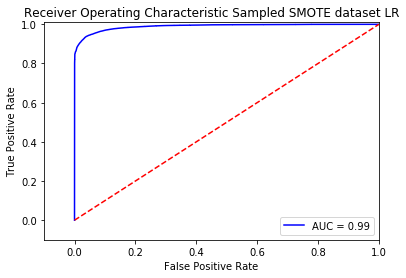

In [29]:
y_pred_sampled_score= temp.decision_function(X_test_sampled_df)
fpr, tpr, thresholds = roc_curve(y_true=y_test_sampled_df, y_score=y_pred_sampled_score)
roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic Sampled SMOTE dataset LR')
plt.plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

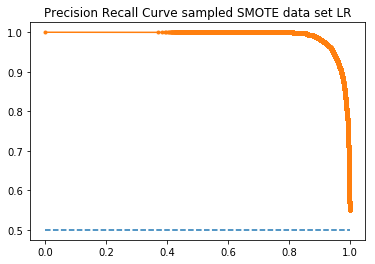

In [58]:
#y_predicted_sample=temp.predict(X_test_sampled_df,batch_size=15)
probs  = temp.predict_proba(X_test_sampled_df)
probs = probs[:,1]
precision, recall, thresholds = precision_recall_curve(y_test_sampled_df, probs)
auc_precisionrecall = auc(recall, precision)
plt.title("Precision Recall Curve sampled SMOTE data set LR")
plt.plot([0, 1], [0.5, 0.5], linestyle='--')
# plot the precision-recall curve for the model
plt.plot(recall, precision, marker='.',label='AUC = %0.2f'% auc_precisionrecall)
# show the plot
plt.show()

In [59]:
print("AUC precision/recall {}".format(auc_precisionrecall))

AUC precision/recall 0.9908411888830085


Test against the actual data set

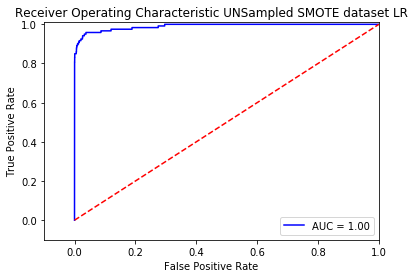

In [60]:
y_pred_score_lr= temp.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred_score_lr)
roc_auc_lr = auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic UNSampled SMOTE dataset LR')
plt.plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

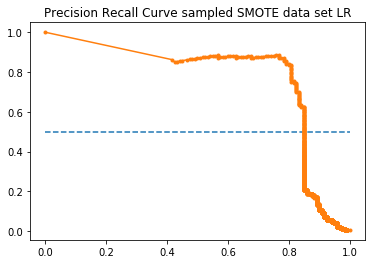

In [56]:
probs  = temp.predict_proba(X_test)
probs = probs[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, probs)
auc_precisionrecall = auc(recall, precision)
plt.title("Precision Recall Curve sampled SMOTE data set LR")
plt.plot([0, 1], [0.5, 0.5], linestyle='--')
# plot the precision-recall curve for the model
plt.plot(recall, precision,label='AUC = %0.2f'%auc_precisionrecall, marker='.')
# show the plot
plt.show()

In [57]:
print("AUC precision/recall {}".format(auc_precisionrecall))

AUC precision/recall 0.7710230317423059


# Using Convolutional Neural Networks

In [39]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

Using TensorFlow backend.


In [40]:
clf = Sequential([
    Dense(units=16, kernel_initializer='uniform', input_dim=29, activation='relu'),
    Dense(units=18, kernel_initializer='uniform', activation='relu'),
    Dropout(0.25),
    Dense(20, kernel_initializer='uniform', activation='relu'),
    Dense(24, kernel_initializer='uniform', activation='relu'),
    Dense(1, kernel_initializer='uniform', activation='sigmoid')
])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [41]:
clf.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                480       
_________________________________________________________________
dense_2 (Dense)              (None, 18)                306       
_________________________________________________________________
dropout_1 (Dropout)          (None, 18)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 20)                380       
_________________________________________________________________
dense_4 (Dense)              (None, 24)                504       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 25        
Total params: 1,695
Trainable params: 1,695
Non-trainable params: 0
_________________________________________________________________


In [0]:
clf.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [43]:
clf.fit(X_train_sampled_df,y_train_sampled_df.values.ravel(), batch_size=15, epochs=30)

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
426472/426472 [==============================] - 35s 81us/step - loss: 0.0385 - acc: 0.9873
Epoch 2/30
426472/426472 [==============================] - 34s 81us/step - loss: 0.0195 - acc: 0.9945
Epoch 3/30
426472/426472 [==============================] - 35s 81us/step - loss: 0.0155 - acc: 0.9959
Epoch 4/30
426472/426472 [==============================] - 34s 81us/step - loss: 0.0134 - acc: 0.9965
Epoch 5/30
426472/426472 [==============================] - 34s 80us/step - loss: 0.0125 - acc: 0.9968
Epoch 6/30
426472/426472 [==============================] - 35s 82us/step - loss: 0.0119 - acc: 0.9971
Epoch 7/30
426472/426472 [==============================] - 34s 80us/step - loss: 0.0106 - acc: 0.9974
Epoch 8/30
426472/426472 [==============================] - 34s 80us/step - loss: 0.0101 - acc: 0.9975
Epoch 9/30
426472/426472 [==============================] - 35s 81us/step - loss: 0.0098 - acc: 0.9977
Epoch 10/30
426472/426472

In [44]:
score = clf.evaluate(X_test_sampled_df, y_test_sampled_df.values.ravel(), batch_size=10)
print('\nAnd the Score is ', score[1] * 100, '%')

142158/142158 [==============================] - 8s 53us/step

And the Score is  99.84805635173652 %


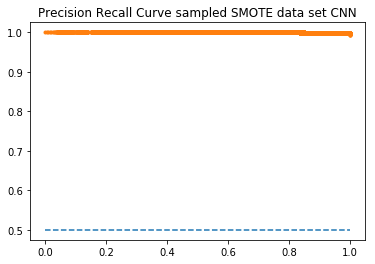

In [63]:
y_predicted_sample_cnn=clf.predict(X_test_sampled_df,batch_size=15)
probs  = clf.predict_proba(X_test_sampled_df)
precision, recall, thresholds = precision_recall_curve(y_test_sampled_df, probs)
auc_precisionrecall = auc(recall, precision)
plt.title("Precision Recall Curve sampled SMOTE data set CNN")
plt.plot([0, 1], [0.5, 0.5], linestyle='--')
# plot the precision-recall curve for the model
plt.plot(recall, precision, marker='.',label='AUC = %0.2f'% auc_precisionrecall)
# show the plot
plt.show()



In [64]:
print("Area under the curve {}".format(auc_precisionrecall))

Area under the curve 0.9996960787987987


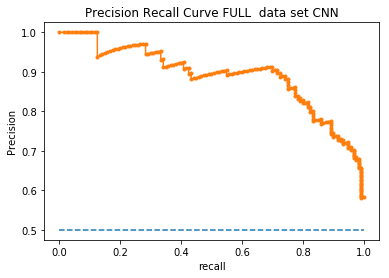

In [61]:

#Now we test it against the actual data
probs  = clf.predict_proba(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, probs)
auc_precisionrecall = auc(recall, precision)
plt.title("Precision Recall Curve FULL  data set CNN")

plt.plot([0, 1], [0.5, 0.5], linestyle='--')
# plot the precision-recall curve for the model
plt.plot(recall, precision, marker='.',label='AUC = %0.2f'%auc_precisionrecall)
# show the plot
plt.xlabel("recall")
plt.ylabel('Precision')
plt.show()

In [62]:
print("Area under the curve {}".format(auc_precisionrecall))

Area under the curve 0.8908629779691996


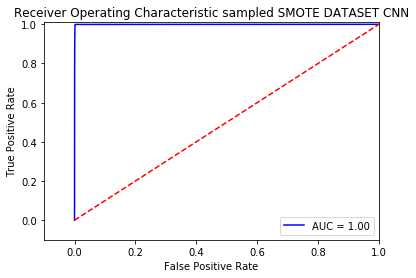

In [47]:
fpr, tpr, thresholds = roc_curve(y_true=y_test_sampled_df, y_score=y_predicted_sample_cnn)
roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic sampled SMOTE DATASET CNN')
plt.plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

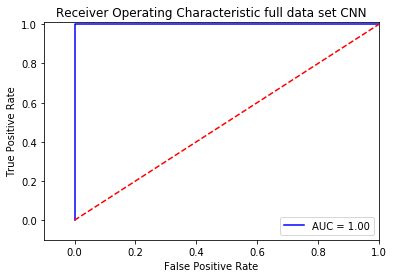

In [48]:
y_predicted_cnn=clf.predict(X_test,batch_size=15)
fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_predicted_cnn)
roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic full data set CNN')
plt.plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()